In [ ]:
#Importing required libraries
import torch
from torch import nn, optim
import torch.onnx
import torch.nn.functional as F
from torchvision.transforms import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from nltk.tokenize import word_tokenize
from tqdm.auto import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

#Select GPU to use otherwise CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

ValueError: mount failed

In [ ]:
#Loading CSV file
captions = pd.read_csv("/content/drive/MyDrive/NN_BASEMODEL/flicke 1k/flickr1k/captions.csv")
captions

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...
...,...,...
4995,2098418613_85a0c9afea.jpg,A brown chow mix dog is standing in front of a...
4996,2098418613_85a0c9afea.jpg,A brown dog standing in a muddy yard .
4997,2098418613_85a0c9afea.jpg,A brown dogs walks near a green van and some j...
4998,2098418613_85a0c9afea.jpg,A large brown dog stands in front of a green v...


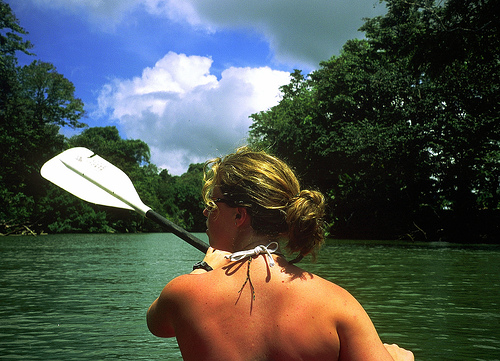

A girl paddling down a large river , as seen from behind her .
A woman kayaking down a river .
A woman paddles a boat down a river .
A woman with a paddle .
A woman with a paddle sits in a boat on the water .


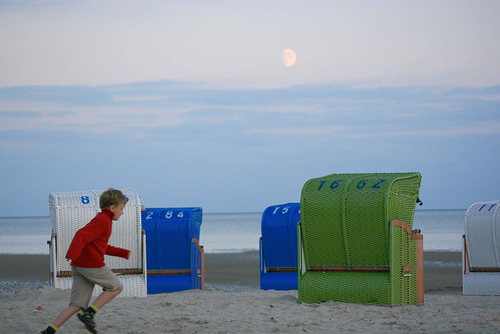

A boy dressed in khaki shorts and a red shirt runs on a beach with green , white and blue structures and a half moon behind him .
A boy in a red sweater running on the beach
A boy wearing a red shirt runs along a beach .
A boy wearing a red sweater runs along a colorful beach .
Young boy in red runs on beach and passes white , blue and green beach huts .


In [ ]:
#Displays a random image
def display_random_data(count=5, seed=1):
    np.random.seed(seed)
    # random choose images == count
    images = np.random.choice(captions['image'].unique(), count)
    # display and their captions
    for image in images:
        # display image
        display(Image.open(f'/content/drive/MyDrive/NN_BASEMODEL/flicke 1k/flickr1k/images/{image}'))
        # display caption
        img_captions = captions.loc[captions['image']==image, 'caption'].tolist()
        for cap in img_captions:
            print(cap)
display_random_data(2)

In [ ]:
#Load and preprocess dataset
class My_Flickr1k(Dataset):
    def __init__(self, root_file, captions, transform=None):

        self.transform = transform
        self.root = root_file
        self.ids = captions

    def __getitem__(self, idx):

        image_path, caption = self.ids[idx]
        image = Image.open(self.root+image_path)
        if self.transform:
            image = self.transform(image)

        return image, caption

    def __len__(self):
        return self.ids.shape[0]

In [ ]:
#Split captions and images into training and test data
def build_datasets_vocab(root_file, captions_file, transform, split=0.15):
    df = pd.read_csv(captions_file)

    vocab = {}
    def create_vocab(caption):
        tokens = [token.lower() for token in word_tokenize(caption)]
        for token in tokens:
            if token not in vocab:
                vocab[token] = len(vocab)

    df["caption"].apply(create_vocab)

    train, valid = train_test_split(df, test_size=split, random_state=42)
    return My_Flickr1k(root_file, train.values, transform), \
           My_Flickr1k(root_file, valid.values, transform), \
           vocab

In [ ]:
nltk.download('punkt_tab')
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])
train_dataset, valid_dataset, vocab = build_datasets_vocab("/content/drive/MyDrive/NN_BASEMODEL/flicke 1k/flickr1k/images/",
                                              "/content/drive/MyDrive/NN_BASEMODEL/flicke 1k/flickr1k/captions.csv",
                                              transform)

id_to_word = {id_: word for word, id_ in vocab.items()}

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/NN_BASEMODEL/flicke 1k/flickr1k/captions.csv")
# MAX_CAPTION_LEN = df["caption"].apply(lambda x: len(word_tokenize(x))).max()
MAX_CAPTION_LEN = 38

In [ ]:
def transform_captions(captions):

    transformed = [[vocab[word.lower()] for word in word_tokenize(caption)] for caption in captions]
    padded = [transform + [vocab["."]]*(MAX_CAPTION_LEN - len(transform)) for transform in transformed]

    return padded

def get_caption(caption_sequence):

    return " ".join([id_to_word[id_] for id_ in caption_sequence if id_ != vocab["."]])

In [ ]:
# Constants
POOLING_FACTOR = 32

In [ ]:
#Defines convolutional and transpose convolutional layers with LeakyReLU activation
class ConvLeak(nn.Module):

    def __init__(self, in_channels, out_channels, kernel_size=5):

        super().__init__()
        self.layer = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels,
                      kernel_size=kernel_size, padding=(kernel_size-1)//2),
            nn.LeakyReLU(),
        )

    def forward(self, x):
        return self.layer(x)


class ConvTransposeLeak(nn.Module):

    def __init__(self, in_channels, out_channels, kernel_size=5):
        super().__init__()
        self.layer = nn.Sequential(
            nn.ConvTranspose2d(in_channels=in_channels, out_channels=out_channels,
                               kernel_size=kernel_size, padding=(kernel_size-1)//2),
            nn.LeakyReLU(),
        )

    def forward(self, x):
        return self.layer(x)

In [ ]:
#Implementing Self Attention
class SelfAttentionConv(nn.Module):
    def __init__(self, in_dim):
        super(SelfAttentionConv, self).__init__()
        self.query_conv = nn.Linear(in_dim, in_dim)
        self.key_conv = nn.Linear(in_dim, in_dim)
        self.value_conv = nn.Linear(in_dim, in_dim)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        # x shape: (batch, features)
        query = self.query_conv(x)
        key = self.key_conv(x)
        value = self.value_conv(x)

        scores = torch.matmul(query.unsqueeze(1), key.unsqueeze(2)) / (x.size(1) ** 0.5)
        attn_weights = self.softmax(scores)
        attended = attn_weights.squeeze(-1) * value
        return attended


In [ ]:
#Defines a VAE encoder that extracts image features through convolution and pooling, then projects them into a latent space
class Encoder(nn.Module):

    def __init__(self, in_channels, out_channels, image_dim, latent_dim):

        super().__init__()

        # constants used

        iW, iH = image_dim
        hW, hH = iW//POOLING_FACTOR, iH//POOLING_FACTOR
        vec_dim = out_channels * hW * hH

        self.layer1 = nn.Sequential(
            ConvLeak(in_channels=in_channels, out_channels=48),
            ConvLeak(in_channels=48, out_channels=48)
        )
        self.layer2 = nn.Sequential(
            ConvLeak(in_channels=48, out_channels=84),
            ConvLeak(in_channels=84, out_channels=84)
        )
        self.layer3 = nn.Sequential(
            ConvLeak(in_channels=84, out_channels=128),
            ConvLeak(in_channels=128, out_channels=128)
        )

        self.layer4 = nn.Sequential(
            ConvLeak(in_channels=128, out_channels=out_channels),
            nn.Flatten()
        )

        self.attn = SelfAttentionConv(vec_dim)


        self.pooling = nn.MaxPool2d(4, return_indices=True)
        self.pooling_2 = nn.MaxPool2d(2, return_indices=True)


        self.hidden = nn.Sequential(
            nn.Linear(in_features = vec_dim, out_features=latent_dim),
            nn.LeakyReLU(),
            nn.Linear(in_features=latent_dim, out_features=latent_dim),
            nn.Tanh()
        )

        self.encoder_mean = nn.Linear(in_features = latent_dim, out_features = vec_dim)
        self.encoder_logstd = nn.Linear(in_features = latent_dim, out_features = vec_dim)


    def generate_code(self, mean, log_std):

        sigma = torch.exp(log_std)
        epsilon = torch.randn_like(mean)
        return (sigma * epsilon) + mean


    def forward(self, x):

        x = self.layer1(x)
        x, indices_1 = self.pooling(x)
        x = self.layer2(x)
        x, indices_2 = self.pooling(x)
        x = self.layer3(x)
        x, indices_3 = self.pooling_2(x)
        x = self.layer4(x)

        x = self.attn(x)


        hidden = self.hidden(x)
        mean, log_std = self.encoder_mean(hidden), self.encoder_logstd(hidden)
        c = self.generate_code(mean, log_std)

        return c, indices_1, indices_2, indices_3, mean, log_std

In [ ]:
#Defines a VAE decoder that reconstructs images from latent vectors
class Decoder(nn.Module):

    def __init__(self, in_channels, out_channels, image_dim):

        super().__init__()

        iW, iH = image_dim
        hW, hH = iW//POOLING_FACTOR, iH//POOLING_FACTOR

        self.layer4 = nn.Sequential(
            nn.Unflatten(1, unflattened_size=(in_channels, hW, hH)),
            ConvTransposeLeak(in_channels=in_channels, out_channels=128)
        )

        self.layer3 = nn.Sequential(
            ConvTransposeLeak(128, 128),
            ConvTransposeLeak(128, 84)
        )
        self.layer2 = nn.Sequential(
            ConvTransposeLeak(84, 84),
            ConvTransposeLeak(84, 48)
        )
        self.layer1 = nn.Sequential(
            ConvTransposeLeak(48, 48),
            ConvTransposeLeak(48, 3)
        )

        self.unpooling = nn.MaxUnpool2d(4)
        self.unpooling_2 = nn.MaxUnpool2d(2)

        self.precision = nn.Parameter(torch.rand(1))


    def generate_data(self, mean, precision):


        sigma = torch.exp(-precision)
        epsilon = torch.randn_like(mean)
        return (sigma * epsilon) + mean

    def forward(self, x, indices_1, indices_2, indices_3):

        x = self.layer4(x)
        x = self.unpooling_2(x, indices_3)
        x = self.layer3(x)
        x = self.unpooling(x, indices_2)
        x = self.layer2(x)
        x = self.unpooling(x, indices_1)
        x = self.layer1(x)

        return x

In [ ]:
# Captioning model using GRU and cross attention over VAE-encoded image features
class CaptionRNN(nn.Module):

    CAPTION_LIMIT = MAX_CAPTION_LEN

    def __init__(self, input_size, vocab_size, embedding_size, hidden_size, stop_index):
        super().__init__()


        self.mlp_l1 = nn.Sequential(
            nn.Linear(in_features=input_size, out_features=input_size),
            nn.LeakyReLU(),
            nn.Linear(in_features=input_size, out_features=hidden_size),
            nn.Tanh()
        )

        self.mlp_l2 = nn.Sequential(
            nn.Linear(in_features=hidden_size, out_features=hidden_size),
            nn.LeakyReLU(),
            nn.Linear(in_features=hidden_size, out_features=vocab_size),
        )


        self.gru = nn.GRU(input_size=embedding_size, hidden_size=hidden_size, batch_first=True)
        self.embedding = nn.Embedding(vocab_size, embedding_size)

        self.stop_index = stop_index


    def generate_caption(self, code):


        h_1 = self.mlp_l1(code)
        prob_1 = F.softmax(self.mlp_l2(h_1), dim=-1)
        y_1 = torch.multinomial(prob_1, 1)

        words = [y_1.item()]
        w_t = self.embedding(y_1)
        y_t = y_1
        h_t = h_1


        while len(words) < CaptionRNN.CAPTION_LIMIT and y_t.item() != self.stop_index:
            h_t = self.gru(w_t.unsqueeze(0), h_t.unsqueeze(0).unsqueeze(0))[0]
            h_t = h_t.squeeze(0).squeeze(0)
            prob_t = F.softmax(self.mlp_l2(h_t), dim=-1)
            y_t = torch.multinomial(prob_t, 1)
            words.append(y_t.item())
            w_t = self.embedding(y_t)

        return words


    def caption_prob(self, code, caption):

        hidden_1 = self.mlp_l1(code)
        probs_1 = F.softmax(self.mlp_l2(hidden_1), dim=1)
        weights = self.embedding(caption)
        output, hidden = self.gru(weights, hidden_1.unsqueeze(0))
        probs_2_above = F.softmax(self.mlp_l2(output[:, :-1]), dim=-1)
        return torch.cat([probs_1.unsqueeze(1), probs_2_above], dim=1)

In [ ]:
# Combines VAE and captioning modules to reconstruct images and generate captions
class VAECaptioner(nn.Module):

    def __init__(self, in_channel, code_channels, image_dim, vocab):
        super().__init__()

        LATENT_DIM = 300
        EMBEDDING_SIZE = 600
        HIDDEN_SIZE = 512
        CODE_FLAT = code_channels*((image_dim[0]*image_dim[1])//(POOLING_FACTOR**2))

        self.vocab = vocab

        self.encoder = Encoder(in_channel, code_channels, image_dim, LATENT_DIM)
        self.decoder = Decoder(code_channels, in_channel, image_dim)
        self.captionr = CaptionRNN(CODE_FLAT, len(vocab), EMBEDDING_SIZE, HIDDEN_SIZE, vocab["."])

    def forward(self, x, y):

        c, indices_1, indices_2, indices_3, mean, log_std = self.encoder(x)
        reconstructed = self.decoder(c, indices_1, indices_2, indices_3)
        caption_prob = self.captionr.caption_prob(c, y)

        return reconstructed, caption_prob, mean, log_std

    def generate_caption(self, x):

        c, indices_1, indices_2, indices_3, mean, log_std = self.encoder(x)
        return self.captionr.generate_caption(c[0])

In [ ]:
#Initializes training parameters, data loaders, model, optimizer, and loss functions for image reconstruction and caption generation
EPOCHS = 3
BATCH_SIZE = 32
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=True)
model = VAECaptioner(3, 128, (128, 128), vocab).to(device)
optimizer = optim.AdamW(model.parameters(), lr=0.0002)
criterion = nn.MSELoss(reduction="sum")
criterion2 = nn.CrossEntropyLoss(reduction="sum")

In [ ]:
#Calculates the total VAE loss
def calculate_loss(reconstructed, caption_prob, images, captions_transformed, mean, log_std):

    size = captions_transformed.shape[0]
    reconstruction_error = criterion(reconstructed, images)
    likelihoods = torch.stack([
        caption_prob[i, np.arange(MAX_CAPTION_LEN), captions_transformed[i]] for i in range(size)])


    log_likelihoods = -torch.log(likelihoods).sum()
    KL_divergence = - (1 - mean.pow(2) - torch.exp(2 * log_std) + (2 *log_std)).sum()

    return reconstruction_error + (log_likelihoods) + KL_divergence, log_likelihoods

In [ ]:
#Training the model while tracking losses
losses = []
caption_losses = []
val_losses = []
val_caption_losses = []
for epoch in range(EPOCHS):
    t = tqdm(train_dataloader, desc=f"Train: Epoch {epoch}")

    for images, captions in t:
        images = images.to(device)
        captions_transformed = torch.LongTensor(transform_captions(captions)).to(device)
        reconstructed, caption_prob, mean, log_std = model(images, captions_transformed)

        loss, caption_loss = calculate_loss(reconstructed, caption_prob, images, captions_transformed, mean, log_std)
        loss.backward()

        optimizer.step()
        optimizer.zero_grad()
        losses.append(loss.item())
        caption_losses.append(caption_loss.item())

    v = tqdm(valid_dataloader, desc=f"Valid: Epoch {epoch}")
    with torch.no_grad():
        for images, captions in v:
            images = images.to(device)
            captions_transformed = torch.LongTensor(transform_captions(captions)).to(device)
            reconstructed, caption_prob, mean, log_std = model(images, captions_transformed)
            loss, caption_loss = calculate_loss(reconstructed, caption_prob, images, captions_transformed, mean, log_std)

            val_losses.append(loss.item())
            val_caption_losses.append(caption_loss.item())

Train: Epoch 0:   0%|          | 0/133 [00:00<?, ?it/s]

Valid: Epoch 0:   0%|          | 0/24 [00:00<?, ?it/s]

Train: Epoch 1:   0%|          | 0/133 [00:00<?, ?it/s]

Valid: Epoch 1:   0%|          | 0/24 [00:00<?, ?it/s]

Train: Epoch 2:   0%|          | 0/133 [00:00<?, ?it/s]

Valid: Epoch 2:   0%|          | 0/24 [00:00<?, ?it/s]

In [ ]:
torch.save(model.state_dict(), 'VAECaptioner.onnx')
from torch.autograd import Variable
trained_model = VAECaptioner(3, 128, (128, 128), vocab)
trained_model.load_state_dict(torch.load('VAECaptioner.onnx'))
dummy_input = Variable(torch.randn(1, 1, 28, 28))
#torch.onnx.export(trained_model, dummy_input, "VAECaptioner.onnx")

In [ ]:
torch_model = VAECaptioner(3, 128, (128, 128), vocab).to(device)
model_path = "VAECaptioner.onnx"

# Initialize model with the weights
map_location = lambda storage, loc: storage
if torch.cuda.is_available():
    map_location = None
torch_model.load_state_dict(torch.load(model_path, map_location=map_location))

<All keys matched successfully>

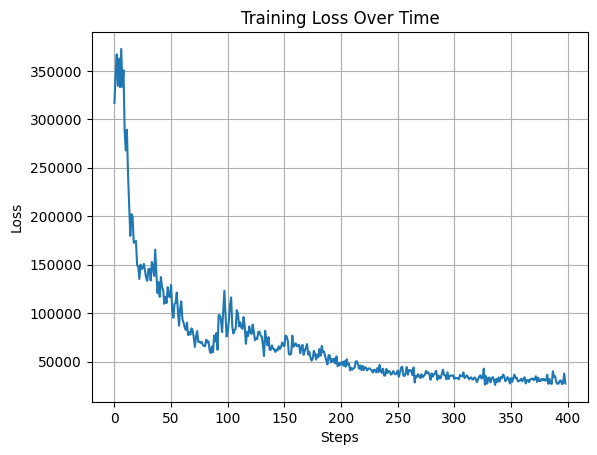

In [ ]:
plt.plot(losses)
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Training Loss Over Time')
plt.grid(True)
plt.show()

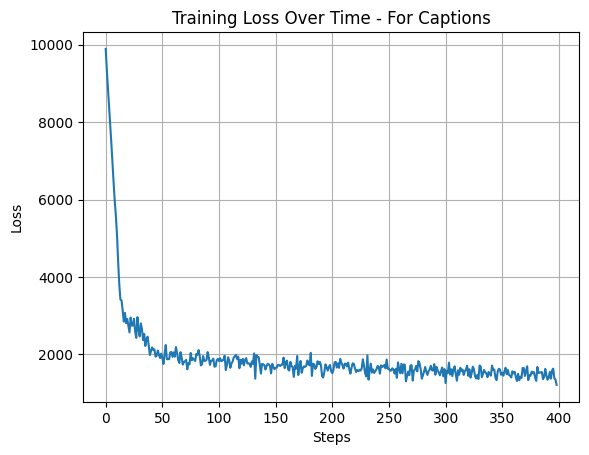

In [ ]:
plt.plot(caption_losses)
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Training Loss Over Time - For Captions')
plt.grid(True)
plt.show()

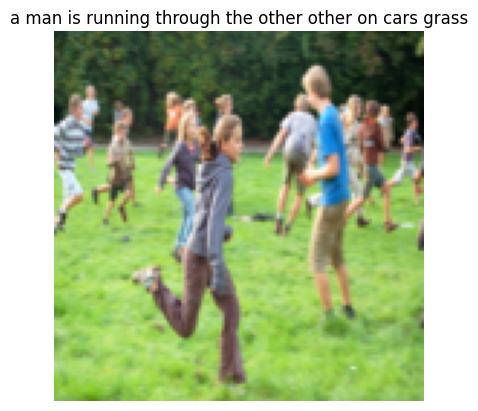

In [ ]:

plt.imshow(images[4].to("cpu").permute(1, 2, 0))
plt.axis("off")
_ = plt.title(get_caption(model.generate_caption(images[4].unsqueeze(0))))